In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import math
from tqdm import tqdm
import numpy as np
import itertools
from collections import defaultdict
import os
from PIL import Image
from pathlib import Path

from insightface.recognition.arcface_torch.backbones.mobilefacenet import get_mbf
import sys
import arc_scores
import helper
import evaluate

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.5):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, inputs, labels):
        cosine = F.linear(
            F.normalize(inputs, p=2, dim=1),
            F.normalize(self.weight, p=2, dim=1)
        )
        sine = torch.sqrt(torch.clamp(1.0 - torch.pow(cosine, 2), 1e-9, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [3]:
class FastImageFolder(Dataset):
    def __init__(self, root, transform=None, extensions=('.jpg', '.jpeg', '.png', '.bmp')):
        self.root = Path(root)
        self.transform = transform
        self.extensions = extensions

        # Scan nhanh và cache paths
        self.samples = []
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        print(f"Scanning {root}...")
        for class_name in self.classes:
            class_dir = self.root / class_name
            class_idx = self.class_to_idx[class_name]

            for ext in self.extensions:
                for img_path in class_dir.glob(f'*{ext}'):
                    self.samples.append((str(img_path), class_idx))

        print(f"Found {len(self.samples)} images in {len(self.classes)} classes")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        image = Image.open(path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, target

In [4]:
test_path = 'test'
test_transforms = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
test_dataset = FastImageFolder(test_path, transform=test_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

Scanning test...
Found 94221 images in 493 classes


In [5]:
BEST_MODEL_PATH = "best.pt" 


device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 512
NUM_EPOCHS = 20
FEATURE_DIM = 512
NUM_CLASSES = 5115

if os.path.exists(BEST_MODEL_PATH):
    checkpoint = torch.load(BEST_MODEL_PATH, map_location=device)

    model = get_mbf(fp16=False, num_features=512).to(device)
    margin = ArcMarginProduct(
        in_features=FEATURE_DIM,
        out_features=NUM_CLASSES,
        s=64.0,
        m=0.4
    ).to(device)

    model_to_load = model.module if hasattr(model, 'module') else model
    margin_to_load = margin.module if hasattr(margin, 'module') else margin

    model_state_dict = checkpoint['model_state_dict']
    new_model_state_dict = {}
    for k, v in model_state_dict.items():
        name = k[7:] if k.startswith('module.') else k
        new_model_state_dict[name] = v

    model_to_load.load_state_dict(new_model_state_dict)
    
    margin_state_dict = checkpoint['margin_state_dict']
    new_margin_state_dict = {}
    for k, v in margin_state_dict.items():
        name = k[7:] if k.startswith('module.') else k
        new_margin_state_dict[name] = v
    
    margin_to_load.load_state_dict(new_margin_state_dict)

    best_tar = checkpoint['best_tar_far']
    print(f"Đã tải thành công mô hình tốt nhất của bạn với TAR@FAR = {best_tar:.4f}")

else:
    print(f"Không tìm thấy file {BEST_MODEL_PATH}. Vui lòng kiểm tra lại đường dẫn.")

Đã tải thành công mô hình tốt nhất của bạn với TAR@FAR = 0.8720


c:\Users\PC\miniconda3\lib\site-packages\torch\_utils.py:99: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  untyped_storage = torch.UntypedStorage(self.size(), device=device)


In [8]:
criterion = nn.CrossEntropyLoss()

model.eval()
margin.eval()

test_loss = []
embs = []
labels = []
with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Evaluating"):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        outputs = F.normalize(outputs, p=2, dim=1)
        logits = margin(outputs, targets)
        loss = criterion(logits, targets)
        test_loss.append(loss.item())

        embs.append(outputs.cpu())
        labels.append(targets.cpu())

test_loss = np.mean(test_loss)
eval_res = evaluate.evaluate(embs, labels, max_per_class=50, n_linspace=1000)

print(f"\n{'='*60}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Eval Metrics:")
print(f"  - Accuracy: {eval_res['accuracy']:.4f}")
print(f"  - ROC AUC: {eval_res['roc_auc']:.4f}")
print(f"  - TAR@FAR1e-3: {eval_res['tar_far_3']:.4f}")
print(f"  - TAR@FAR1e-4: {eval_res['tar_far_4']:.4f}")
print(f"  - Threshold: {eval_res['threshold']:.4f}")
print(f"{'='*60}\n")

Evaluating:   0%|          | 0/185 [00:00<?, ?it/s]c:\DL\insightface\recognition\arcface_torch\backbones\mobilefacenet.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.fp16):
Evaluating: 100%|██████████| 185/185 [02:01<00:00,  1.52it/s]



Test Loss: 50.7593
Eval Metrics:
  - Accuracy: 0.9553
  - ROC AUC: 0.9838
  - TAR@FAR1e-3: 0.8515
  - TAR@FAR1e-4: 0.7533
  - Threshold: 0.2010



In [14]:
from view import eval_pairs, sample_correct_pairs, sample_incorrect_pairs, show_pairs

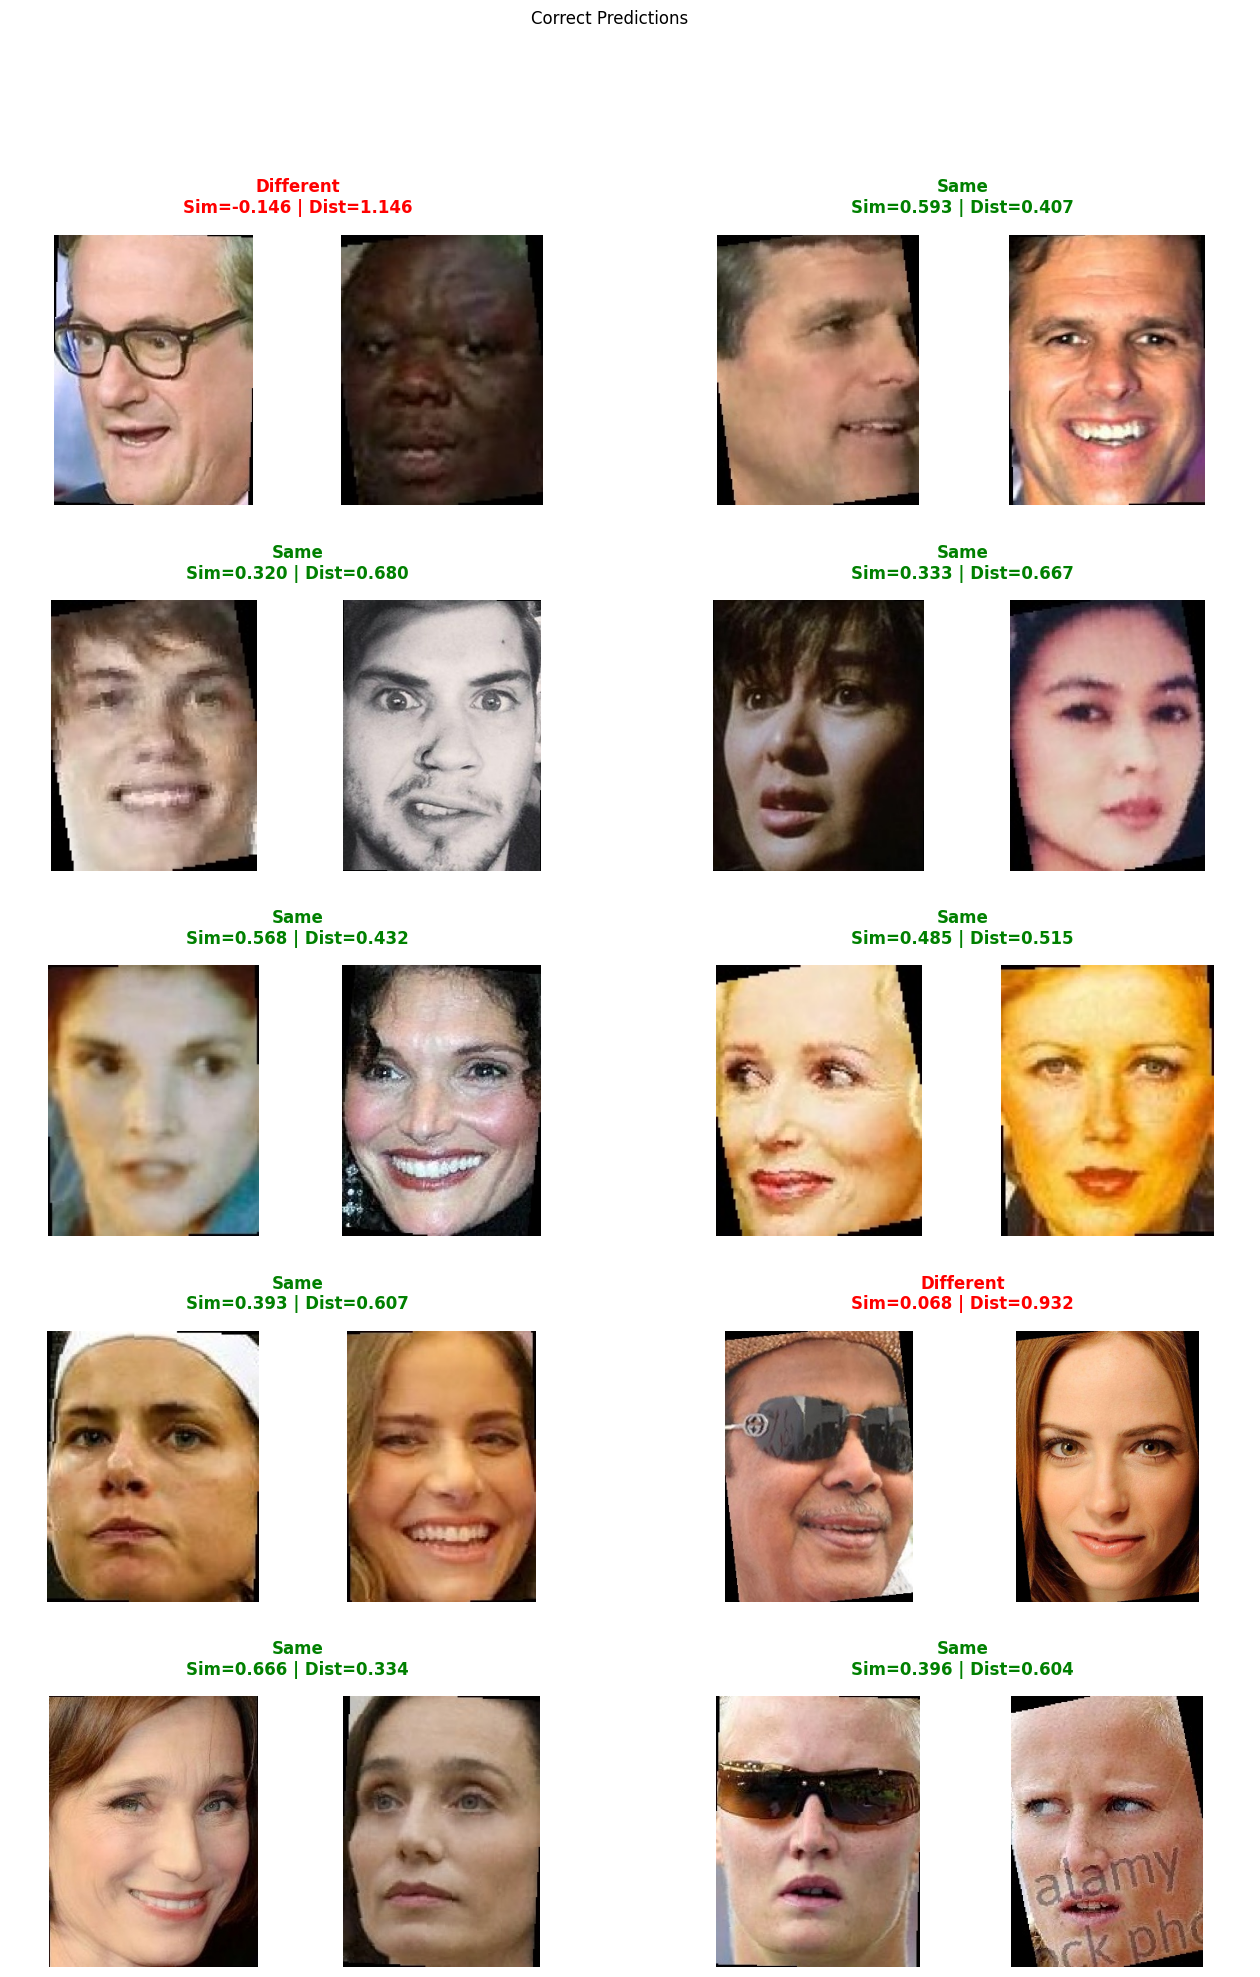

In [ ]:
preds, pairs, sim_scores = eval_pairs(
    embs,
    labels,
    generate_pairs_fn=evaluate.generate_balanced_pairs,
    threshold=0.20
)

paths = sample_correct_pairs(
    pairs, preds, sim_scores,
    test_dataset,
    n=10
)

show_pairs(paths, title="Correct Predictions")

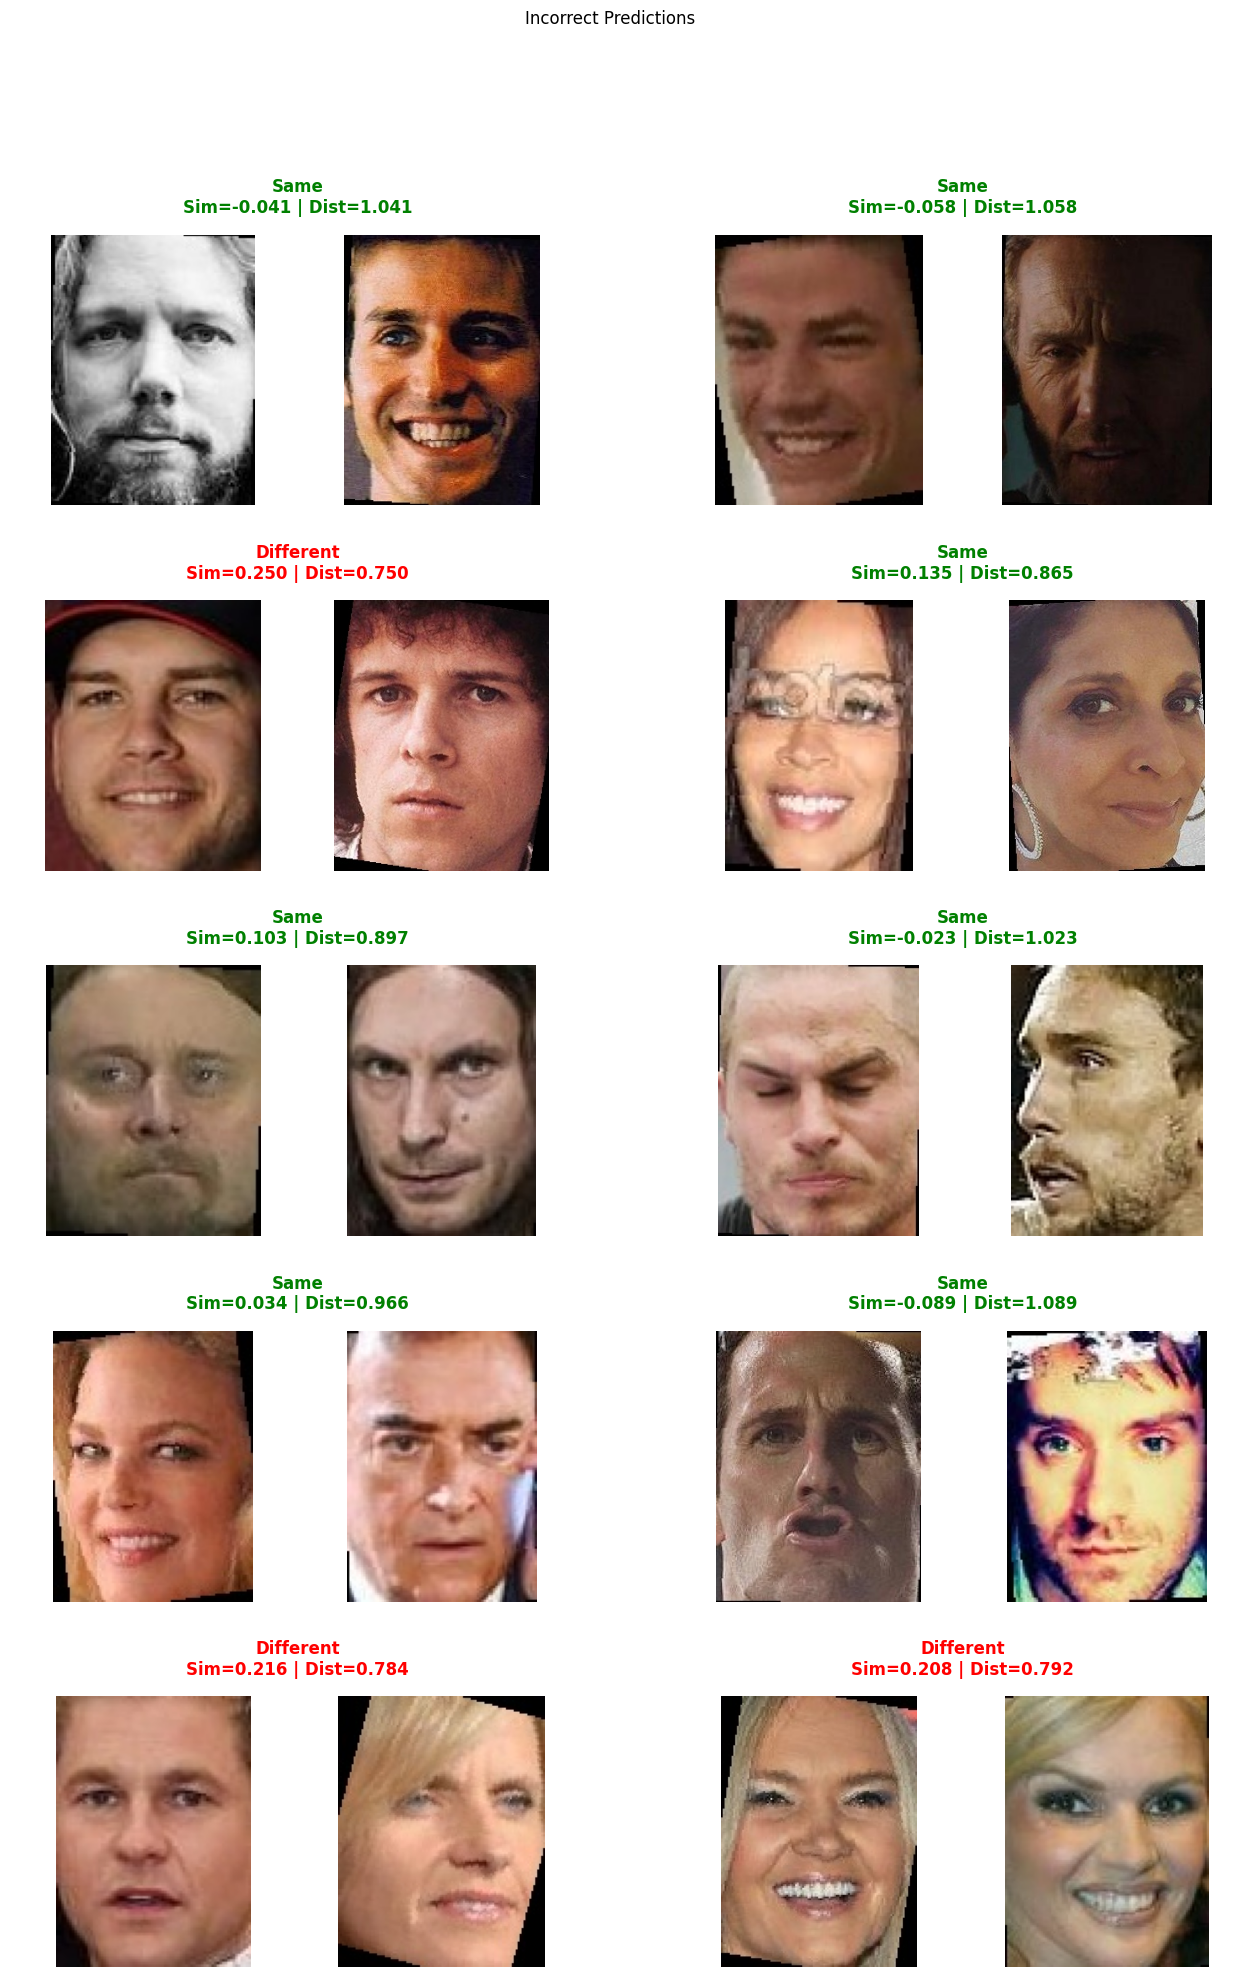

In [15]:
paths = sample_incorrect_pairs(
    pairs, preds, sim_scores,
    test_dataset,
    n=10
)

show_pairs(paths, title="Incorrect Predictions")